In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Set the base path
weights_path = 'results/kdv/weights_u'
data_path = 'results/kdv/data_u'
figures_path = 'results/kdv/figures_u'

In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import time

In [6]:
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

In [7]:
from koopmanlib.kdv_functions import *
from koopmanlib.functions import *

In [8]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)

# inner loop
# # Set the time sample grid.
# dt = 0.4 / (Nx**2)
T = 0.01
# Nt = int(T / dt)
# dt = T / Nt
# t = np.linspace(0, T, Nt)

In [9]:
def v_func(x, c):
    return np.exp(-25 * (x - c)**2)

c1, c2, c3 = -np.pi/2, 0, np.pi/2
v1 = v_func(x, c1).reshape(1,-1)
v2 = v_func(x, c2).reshape(1,-1)
v3 = v_func(x, c3).reshape(1,-1)

v_list = np.concatenate([v1,v2,v3], axis=0)

In [10]:
umax = 1
umin = -umax

# Generate data

In [11]:
target_dim = Nx
param_dim = 3
# n_init = 1000
# traj_len = 200

In [12]:
# traj_len = 500

# n_init = 100

# seed_IC = np.random.randint(0,100,size=(n_init,))
# seed_IC

# y0_list = []
# for seed in seed_IC:
#     y0 = kdv_exact(x, seed)
#     y0_list.append(y0)
# y0_list = np.asarray(y0_list)

# y0_list.shape

# param_list_group = np.random.uniform(low=0, high=1, size=(n_init, traj_len, param_dim)) * (umax - umin) + umin

# soln_outer_list = []
# for y0, param_list in zip(y0_list, param_list_group):
#     # Calculate inner solution for each y0 and param_list (for one trajectory)
#     soln_inner_list = [y0]
#     for param in param_list:
#         # Solve the equation using the scipy integrator
#         soln = kdv_solution(y0, t, L, param, v_list)
#         y0 = soln[-1]
#         soln_inner_list.append(y0)

#     soln_inner_list = np.asarray(soln_inner_list)
    
#     soln_outer_list.append(soln_inner_list)
    
# soln_outer_list = np.asarray(soln_outer_list)

# soln_outer_list.shape

# param_list_group.shape

# data_x = soln_outer_list[:,:-1,:].reshape(-1, target_dim)
# data_y = soln_outer_list[:,1:,:].reshape(-1, target_dim)
# data_u = param_list_group.reshape(-1,param_dim)

In [13]:
# # Save the array to a CSV file
# np.savetxt('results/kdv/data/kdv_data_x.csv', data_x, delimiter=',')
# np.savetxt('results/kdv/data/kdv_data_y.csv', data_y, delimiter=',')
# np.savetxt('results/kdv/data/kdv_data_u.csv', data_u, delimiter=',')

In [14]:
# # Load the CSV file
# data_x = np.loadtxt('results/kdv/data/kdv_data_x_500.csv', delimiter=',')
# data_y = np.loadtxt('results/kdv/data/kdv_data_y_500.csv', delimiter=',')
# data_u = np.loadtxt('results/kdv/data/kdv_data_u_500.csv', delimiter=',')

In [16]:
print('load data')
X = pd.read_csv(os.path.join(data_path,'kdv_X.csv'), header=None)
Y = pd.read_csv(os.path.join(data_path,'kdv_Y.csv'), header=None)
U = pd.read_csv(os.path.join(data_path,'kdv_U.csv'), header=None)

data_x = X.values.T
data_y = Y.values.T
data_u = U.values.T

load data


# Build model

In [17]:
from koopmanlib.dictionary import PsiNN, PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

In [18]:
from tensorflow.keras.optimizers import Adam

In [19]:
n_psi_train = 3
# n_psi = 1 + target_dim + n_psi_train
n_psi = 1 + 1 + 1 + n_psi_train # constant + momentum + mean + NN

In [20]:
dic_pk = PsiNN_obs(layer_sizes=[16,16], n_psi_train=n_psi_train, dx=dx)

In [21]:
solver_pk = KoopmanParametricDLSolver(target_dim=target_dim, 
                                      param_dim=param_dim, 
                                      n_psi=n_psi,
                                      dic=dic_pk)

In [22]:
model_pk, model_K_u_pred_pk = solver_pk.generate_model(layer_sizes=[36,36])

2023-09-19 13:42:03.092878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

In [24]:
model_pk.compile(optimizer=Adam(0.001), loss='mse')

In [25]:
lr_callbacks = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                    factor=0.1,
                                                    patience=50,
                                                    verbose=0,
                                                    mode='auto',
                                                    min_delta=0.0001,
                                                    cooldown=0,
                                                    min_lr=1e-6)

In [26]:
# history = model_pk.fit(x=[data_x, data_y, data_u], 
#                     y=zeros_data_y_train, 
# #                     validation_data = ([data_x_valid, data_y_valid, data_u_valid], zeros_data_y_valid),
#                     epochs=500, 
#                     batch_size=1024,
#                     callbacks=lr_callbacks,
#                     verbose=1)

In [27]:
# model_pk.save_weights(os.path.join(weights_path,'pk_kdv_mass_momentum_weights_psi3.h5'))

In [28]:
model_pk.load_weights(os.path.join(weights_path,'pk_kdv_mass_momentum_weights_psi3.h5'))

# Prediction

In [29]:
def compute_pk_obs(y0, param_list, B_obs):
    param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1,-1)
    
    psi_y = dic_pk(y0)
    obs_list = [psi_y@B_obs]
    
    tau = param_list.shape[0]

    for i in range(tau):
        psi_y = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_y@B_obs
        obs_list.append(obs_next)
        
    return np.squeeze(np.asarray(obs_list))

def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv_solution(y0_loop, T, L, param, v_list, x)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

pred_traj_number = 5
np.random.seed(12)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number,2))

y0_pred_list=[]
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)

for seed_x, seed_u in seed_list:
    # Forward prediction problem setting
    y0_pred = kdv_exact(x, seed=seed_x) 
    

    # Set the seed of param_list
    np.random.seed(seed_u)

    param_pred = np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
    
    y0_pred_list.append(y0_pred)
    param_pred_list.append(param_pred)



error_mass_list_pk, error_momentum_list_pk = compute_obs_error(dic=dic_pk,
                                                           compute_kdv_soln_func=compute_kdv_soln,
                                                           compute_obs_func_model=compute_pk_obs,
                                                           error_func=compute_diff_ratio_one_traj,
                                                           y0_pred_list=y0_pred_list,
                                                           param_pred_list=param_pred_list,
                                                           dx=dx)

mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(error_mass_list_pk)
momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = compute_stat_info(error_momentum_list_pk)



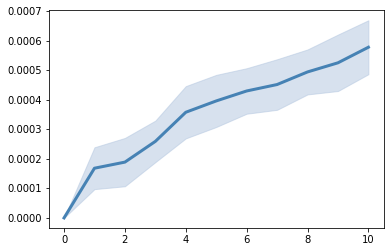

In [30]:
t_axis = np.arange(0, traj_len_pred+1, 1)
plt.plot(mass_mean_pk, label='P-Koopman', color='steelblue', linewidth=3)
plt.fill_between(t_axis, np.maximum(mass_mean_minus_pk,0), mass_mean_plus_pk, color='lightsteelblue', alpha=0.5)

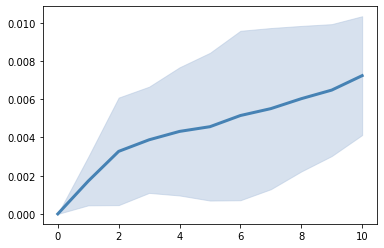

In [31]:
t_axis = np.arange(0, traj_len_pred+1, 1)
plt.plot(momentum_mean_pk, label='P-Koopman', color='steelblue', linewidth=3)
plt.fill_between(t_axis, np.maximum(momentum_mean_minus_pk,0), momentum_mean_plus_pk, color='lightsteelblue', alpha=0.5)

In [32]:
# mass_dict_error_pk = {'mean': mass_mean_pk,
#              'std': mass_std_pk,
#              'mean_plus':mass_mean_plus_pk,
#              'mean_minus':mass_mean_minus_pk}
# np.save(os.path.join(data_path,'mass_error_pk.npy'), mass_dict_error_pk)


# momentum_dict_error_pk = {'mean': momentum_mean_pk,
#              'std': momentum_std_pk,
#              'mean_plus':momentum_mean_plus_pk,
#              'mean_minus':momentum_mean_minus_pk}
# np.save(os.path.join(data_path,'momentum_error_pk.npy'), momentum_dict_error_pk)

# Tracking problem

In [33]:
from scipy.optimize import minimize

In [34]:
# Testing reference

y0_track = np.zeros(shape=(Nx, )) + 0.2

In [35]:
# y0_track = kdv_exact(x, seed=10)

In [36]:

Tsim_track = 10

traj_len_track = int(Tsim_track / T)



### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim))+0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5

In [37]:
tau = 10

In [38]:
# soln_ref = np.loadtxt(os.path.join(data_path,'track_soln_ref'), delimiter=',')

In [39]:
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1,1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1,1))

In [40]:
0.3 * 128 *dx

1.8997977621708355

In [41]:
mass_ref.shape

TensorShape([1000, 1])

In [42]:
def mpc_loss_pk(param, tau, ref_list, y0, B):
    param = tf.reshape(param, shape=(int(param.shape[0]/param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1,-1)
    psi_y = dic_pk(y0)
    
    for i in range(tau):
        psi_x = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_x@B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)
    
    ref_loss= tf.reduce_sum(loss_list)
    param_loss = 0.005 * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))
    
    loss = ref_loss + param_loss
    
#     loss = ref_loss
    return loss   

In [43]:
def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss):
    
    bounds= []
    for i in range(tau*param_dim):
        bounds.append((-1,1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []
    for current_time in range(traj_len-tau-1):
        print('current time step: ', current_time)
        start_time = time.time()
        # This needs param_init is a scalor

        param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

        results = minimize(loss, 
                       x0=param_init,
                       args = (tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B),
                       bounds=bounds)

        param = results.x.reshape(tau, param_dim)[0]
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, L, param, v_list, x)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)
        end_time = time.time()

        print('loss: ', results.fun)
#         print('time: ', end_time-start_time)
        
    current_time = current_time + 1
        
    print('current time step: ', current_time)
    start_time = time.time()
    # This needs param_init is a scalor

    param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

    results = minimize(loss, 
                   x0=param_init,
                   args = (tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B),
                   bounds=bounds)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, L, param_curr, v_list, x)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)
        end_time = time.time()

    print('loss: ', results.fun)
        
    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)
    
    return opt_control_list, y0_mpc_loop_list

In [44]:
# def KoopmanMPC(y0, traj_len, soln_ref, kdv_solver, B, loss):
    
#     bounds= []
#     for i in range(tau*param_dim):
#         bounds.append((-1,1))

#     y0_mpc_loop_list = [y0]
#     opt_control_list = []
#     for current_time in range(traj_len):
#         print('current time step: ', current_time)
#         start_time = time.time()
#         # This needs param_init is a scalor

#         param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim, )) * (umax - umin) + umin

#         results = minimize(loss, 
#                        x0=param_init,
#                        args = (tau, soln_ref[current_time+1:current_time+1+tau,:], y0_mpc_loop_list[-1], B),
#                        bounds=bounds)

#         param = results.x.reshape(tau, param_dim)[0]
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, L, param, v_list, x)
#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param)
#         end_time = time.time()

#         print('loss: ', results.fun)
        
#     opt_control_list = np.asarray(opt_control_list)
#     y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)
    
#     return opt_control_list, y0_mpc_loop_list

# Inverse Problem

In [45]:
B_mass = dic_pk.generate_B_mass(mass_ref)
B_momentum = dic_pk.generate_B_momentum(momentum_ref)

## Track mass

In [46]:
pk_opt_control_mass, pk_kdv_opt_mass_soln = KoopmanMPC(y0=y0_track,
                                                       tau=tau,
                                                traj_len=traj_len_track,
                                                soln_ref=mass_ref, 
                                                kdv_solver=kdv_solution,
                                                B=B_mass,
                                                loss=mpc_loss_pk)

current time step:  0
loss:  3.9783848817078105
current time step:  1
loss:  3.923465133724986
current time step:  2
loss:  3.869272879468575
current time step:  3
loss:  3.815810067230614
current time step:  4
loss:  3.763054754492774
current time step:  5
loss:  3.711008851472574
current time step:  6
loss:  3.6596813629700318
current time step:  7
loss:  3.6090411462419953
current time step:  8
loss:  3.55905261829889
current time step:  9
loss:  3.5097340227302443
current time step:  10
loss:  3.461087231786485
current time step:  11
loss:  3.413078786843107
current time step:  12
loss:  3.365737658527351
current time step:  13
loss:  3.3190057569076306
current time step:  14
loss:  3.2728924538731086
current time step:  15
loss:  3.227442819691929
current time step:  16
loss:  3.1825666314759467
current time step:  17
loss:  3.1382957827643985
current time step:  18
loss:  3.0946232936070706
current time step:  19
loss:  3.051528875099288
current time step:  20
loss:  3.0090426037

loss:  0.35721821671432724
current time step:  168
loss:  0.3519404623570347
current time step:  169
loss:  0.34673665409368387
current time step:  170
loss:  0.341609355024143
current time step:  171
loss:  0.33656253674215625
current time step:  172
loss:  0.3315848155169987
current time step:  173
loss:  0.32667949743150076
current time step:  174
loss:  0.32184410098647886
current time step:  175
loss:  0.31707822906183014
current time step:  176
loss:  0.3123816275058368
current time step:  177
loss:  0.3077542310215462
current time step:  178
loss:  0.3031957073246077
current time step:  179
loss:  0.2987136147109296
current time step:  180
loss:  0.2942867335903505
current time step:  181
loss:  0.28992244542199946
current time step:  182
loss:  0.28562068159605747
current time step:  183
loss:  0.2813814517999178
current time step:  184
loss:  0.27720024441823404
current time step:  185
loss:  0.27308260767608256
current time step:  186
loss:  0.2690356390776614
current time st

loss:  0.030826698728253842
current time step:  330
loss:  0.030357714399932574
current time step:  331
loss:  0.029896138170823042
current time step:  332
loss:  0.029442293969551718
current time step:  333
loss:  0.02899473324427549
current time step:  334
loss:  0.028555320236283793
current time step:  335
loss:  0.028122683771801934
current time step:  336
loss:  0.02769549327887546
current time step:  337
loss:  0.027274810559774407
current time step:  338
loss:  0.026860376797466064
current time step:  339
loss:  0.026452321317490497
current time step:  340
loss:  0.026050565468519162
current time step:  341
loss:  0.025654935168719434
current time step:  342
loss:  0.02526551832748618
current time step:  343
loss:  0.024882171320470162
current time step:  344
loss:  0.02450326595745724
current time step:  345
loss:  0.02413031100311993
current time step:  346
loss:  0.02376363018263251
current time step:  347
loss:  0.02340346221916589
current time step:  348
loss:  0.0230490815

loss:  0.0027198720972919596
current time step:  488
loss:  0.0026780364911556053
current time step:  489
loss:  0.002637118405998713
current time step:  490
loss:  0.0025969703130612224
current time step:  491
loss:  1.6373068234521015
current time step:  492
loss:  3.2713979153928627
current time step:  493
loss:  4.904872212229517
current time step:  494
loss:  6.537740212695568
current time step:  495
loss:  8.170011091005502
current time step:  496
loss:  9.8016920443527
current time step:  497
loss:  11.432791268552617
current time step:  498
loss:  13.06331234341864
current time step:  499
loss:  14.69325492956849
current time step:  500
loss:  16.322620279216366
current time step:  501
loss:  16.132151118371265
current time step:  502
loss:  15.943753377980567
current time step:  503
loss:  15.757427476798476
current time step:  504
loss:  15.57313139541774
current time step:  505
loss:  15.390852061198437
current time step:  506
loss:  15.210552250476141
current time step:  50

loss:  2.3627335197966652
current time step:  654
loss:  2.3306932485397396
current time step:  655
loss:  2.299060216277897
current time step:  656
loss:  2.2678246325715725
current time step:  657
loss:  2.2369728239832276
current time step:  658
loss:  2.206521216919078
current time step:  659
loss:  2.1764550035762515
current time step:  660
loss:  2.1467708974542927
current time step:  661
loss:  2.117451465117834
current time step:  662
loss:  2.088498723842926
current time step:  663
loss:  2.059935230596754
current time step:  664
loss:  2.0317368720546
current time step:  665
loss:  2.003893710166657
current time step:  666
loss:  1.9764088434840479
current time step:  667
loss:  1.9492730930679947
current time step:  668
loss:  1.9224729799727769
current time step:  669
loss:  1.8960314149976887
current time step:  670
loss:  1.8699336701446823
current time step:  671
loss:  1.8441705621726958
current time step:  672
loss:  1.8187328050468534
current time step:  673
loss:  1.

loss:  0.21685875661186765
current time step:  818
loss:  0.21357207088072402
current time step:  819
loss:  0.21033505425175814
current time step:  820
loss:  0.20714726670740619
current time step:  821
loss:  0.20400514359838737
current time step:  822
loss:  0.20090802308910274
current time step:  823
loss:  0.19785395152032823
current time step:  824
loss:  0.1948431483418048
current time step:  825
loss:  0.19187774620544812
current time step:  826
loss:  0.18895714421265244
current time step:  827
loss:  0.18608301081693032
current time step:  828
loss:  0.1832528789211416
current time step:  829
loss:  0.18046610238665395
current time step:  830
loss:  0.17771978540293631
current time step:  831
loss:  0.1750128047234438
current time step:  832
loss:  0.17234350668671955
current time step:  833
loss:  0.1697140245062037
current time step:  834
loss:  0.1671237631488209
current time step:  835
loss:  0.1645729702431626
current time step:  836
loss:  0.16206291948244064
current ti

loss:  0.01754863474634014
current time step:  979
loss:  0.0172752277337967
current time step:  980
loss:  0.017002214166687023
current time step:  981
loss:  0.016734554588566018
current time step:  982
loss:  0.01647503156848239
current time step:  983
loss:  0.016217080471472703
current time step:  984
loss:  0.01596248544607876
current time step:  985
loss:  0.015712330295435895
current time step:  986
loss:  0.015464166348025605
current time step:  987
loss:  0.015219115481826124
current time step:  988
loss:  0.014979947194566336
current time step:  989
loss:  0.014744122931901747


In [47]:
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_pk_mass_kdv_opt_control.csv'), pk_opt_control_mass, delimiter=',')
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_pk_mass_kdv_opt_soln.csv'), pk_kdv_opt_mass_soln, delimiter=',')

In [48]:
# pk_opt_control_mass = np.loadtxt(os.path.join(data_path,'no_penalty_pk_mass_kdv_opt_control_20s_greedy.csv'), delimiter=',')
# pk_kdv_opt_mass_soln = np.loadtxt(os.path.join(data_path,'no_penalty_pk_mass_kdv_opt_soln_20s_greedy.csv'), delimiter=',')

In [49]:
pk_kdv_opt_mass = dx * tf.reduce_sum(pk_kdv_opt_mass_soln, axis=-1)

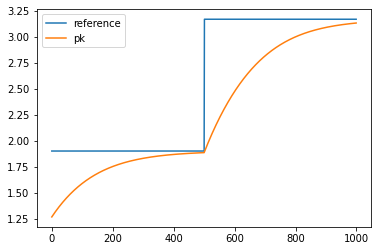

In [50]:
plt.plot(mass_ref, label='reference')
plt.plot(pk_kdv_opt_mass, label='pk')
plt.legend()

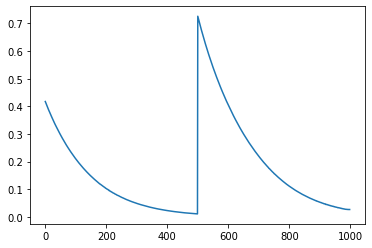

In [51]:
plt.plot(pk_opt_control_mass[:,0])

## Track momentum

In [52]:
pk_opt_control_momentum, pk_kdv_opt_momentum_soln = KoopmanMPC(y0=y0_track,
                                                               tau=tau,
                                                traj_len=traj_len_track,
                                                soln_ref=momentum_ref, 
                                                kdv_solver=kdv_solution,
                                                B=B_momentum,
                                                loss=mpc_loss_pk)

current time step:  0
loss:  1.0011890593983148
current time step:  1
loss:  0.9987767369638582
current time step:  2
loss:  0.9963873762467773
current time step:  3
loss:  0.9940015461346333
current time step:  4
loss:  0.9916096552002902
current time step:  5
loss:  0.9892267799797485
current time step:  6
loss:  0.9868437997693456
current time step:  7
loss:  0.9844607726467137
current time step:  8
loss:  0.982088962918696
current time step:  9
loss:  0.9797144725770245
current time step:  10
loss:  0.9773348861583282
current time step:  11
loss:  0.9749527590896805
current time step:  12
loss:  0.9725744185603893
current time step:  13
loss:  0.9702017069730091
current time step:  14
loss:  0.9678343487892488
current time step:  15
loss:  0.9654686647091231
current time step:  16
loss:  0.9631018468691742
current time step:  17
loss:  0.9607373072734615
current time step:  18
loss:  0.9583783262764862
current time step:  19
loss:  0.9560245749509445
current time step:  20
loss:  0


KeyboardInterrupt



In [ ]:
pk_kdv_opt_momentum = dx * tf.reshape(tf.math.reduce_sum(tf.square(pk_kdv_opt_momentum_soln), axis=-1), shape=(-1,1))

In [ ]:
plt.plot(momentum_ref, label='reference')
plt.plot(pk_kdv_opt_momentum, label='pk')
plt.legend()

In [ ]:
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_pk_momentum_kdv_opt_control.csv'), pk_opt_control_momentum, delimiter=',')
np.savetxt(os.path.join(data_path,'mpc/0.005_penalty_pk_momentum_kdv_opt_soln.csv'), pk_kdv_opt_momentum_soln, delimiter=',')

# Controllability

In [84]:
# Randomly sample control
np.random.seed(seed=111)
n_control_samples = 2000
control_samples = np.random.uniform(low=0, high=1, size=(n_control_samples, param_dim)) * (umax - umin) + umin

In [85]:
pk_K_matrix = solver_pk.model_K_u(control_samples)

In [86]:
pk_K_matrix.shape

TensorShape([2000, 6, 6])

In [87]:
identity_matrix = np.eye(N=pk_K_matrix.shape[-1])

pk_A_matrix = (pk_K_matrix - identity_matrix) / T

pk_A_vector = tf.reshape(pk_A_matrix, shape=(pk_A_matrix.shape[0], pk_A_matrix.shape[-1]*pk_A_matrix.shape[-1]))

rank = np.linalg.matrix_rank(pk_A_vector)

U, S, VT = np.linalg.svd(pk_A_vector)

In [88]:
pk_A_vector.shape

TensorShape([2000, 36])

In [89]:
np.sum(S > 1e-5)

36

In [103]:
S

array([6.02670555e+03, 7.48353762e+02, 6.00239581e+02, 2.71091241e+02,
       2.36689116e+01, 1.76426264e+01, 1.34482483e+01, 6.65744282e+00,
       5.79384862e+00, 4.56737246e+00, 4.18792280e+00, 3.83096033e+00,
       3.31727920e+00, 2.08279310e+00, 1.74862975e+00, 1.58414251e+00,
       1.29468398e+00, 9.96616789e-01, 5.89629844e-01, 4.44365404e-01,
       2.71178700e-01, 1.49223411e-01, 9.70483159e-02, 7.47573395e-02,
       4.92078437e-02, 4.31219216e-02, 3.31555738e-02, 2.89510136e-02,
       2.42352778e-02, 2.33716316e-02, 1.33080534e-02, 9.51673482e-03,
       5.39329255e-03, 4.73947868e-03, 4.22526570e-03, 3.04664154e-03])

In [104]:
label_font = 16
ticks_font = 16

In [161]:
np.linspace(1,36,8)

array([ 1.,  6., 11., 16., 21., 26., 31., 36.])

Text(0, 0.5, '$\\sigma_{i}$')

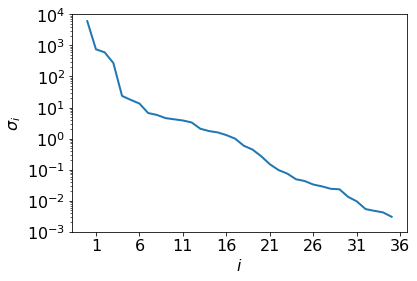

In [170]:
plt.plot(S, linewidth=2)
plt.yscale('log')

custom_xticks = np.linspace(1,36,8)
plt.xticks(custom_xticks, fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)

# plt.xlim(0,37) 
plt.ylim(1e-3,1e4) 
plt.xlabel(r'$i$', fontsize=label_font)
plt.ylabel(r'$\sigma_{i}$', fontsize=label_font)

# plt.savefig(os.path.join(figures_path, 'pk_eigenvalue.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'pk_eigenvalue.pdf'), dpi=200, bbox_inches='tight')

# Check exact control

In [197]:
def v_func(x, c):
    return np.exp(-25 * (x - c)**2)

c1, c2, c3 = -np.pi/2, 0, np.pi/2
v1 = v_func(x, c1).reshape(1,-1)
v2 = v_func(x, c2).reshape(1,-1)
v3 = v_func(x, c3).reshape(1,-1)

v_list = np.concatenate([v1,v2,v3], axis=0)

In [198]:
x

array([-3.14159265, -3.09211875, -3.04264485, -2.99317095, -2.94369705,
       -2.89422315, -2.84474925, -2.79527535, -2.74580145, -2.69632755,
       -2.64685365, -2.59737975, -2.54790585, -2.49843195, -2.44895805,
       -2.39948415, -2.35001025, -2.30053635, -2.25106245, -2.20158855,
       -2.15211465, -2.10264075, -2.05316685, -2.00369295, -1.95421905,
       -1.90474515, -1.85527125, -1.80579735, -1.75632345, -1.70684955,
       -1.65737565, -1.60790175, -1.55842785, -1.50895395, -1.45948005,
       -1.41000615, -1.36053225, -1.31105835, -1.26158445, -1.21211055,
       -1.16263665, -1.11316275, -1.06368885, -1.01421495, -0.96474105,
       -0.91526715, -0.86579325, -0.81631935, -0.76684545, -0.71737155,
       -0.66789765, -0.61842375, -0.56894985, -0.51947595, -0.47000205,
       -0.42052815, -0.37105425, -0.32158035, -0.27210645, -0.22263255,
       -0.17315865, -0.12368475, -0.07421085, -0.02473695,  0.02473695,
        0.07421085,  0.12368475,  0.17315865,  0.22263255,  0.27

In [199]:
def v1_func(x):
    return np.exp(-25 * (x + np.pi/2)**2)

def v2_func(x):
    return np.exp(-25 * (x)**2)

def v3_func(x):
    return np.exp(-25 * (x - np.pi/2)**2)

In [200]:
from scipy import integrate

In [201]:
integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi) 

In [202]:
integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi) 

In [203]:
integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi) 

In [205]:
rhs_value = integral_1 + integral_2 + integral_3

In [206]:
rhs_value

1.06347231054331

In [190]:
mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1,1))

In [191]:
mass_y0_track

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.26653184]])>

In [194]:
dx * tf.reshape(tf.math.reduce_sum(tf.square(y0_track), axis=-1), shape=(-1,1))

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.25330637]])>

In [192]:
track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T) 

NameError: name 'rhs_value' is not defined

In [193]:
mass_y0_track

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.26653184]])>

In [760]:
track_step_1 

59

In [761]:
track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

In [762]:
track_step_2

119

In [763]:
control_exact_opt = np.zeros(shape= pk_opt_control_mass.shape, dtype='float64')

In [764]:
control_exact_opt[:track_step_1] = 0.5
control_exact_opt[500:500+track_step_2] = 0.5

In [765]:
# kdv_opt_control = compute_kdv_soln(y0_track, pk_opt_control_mass)
kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)

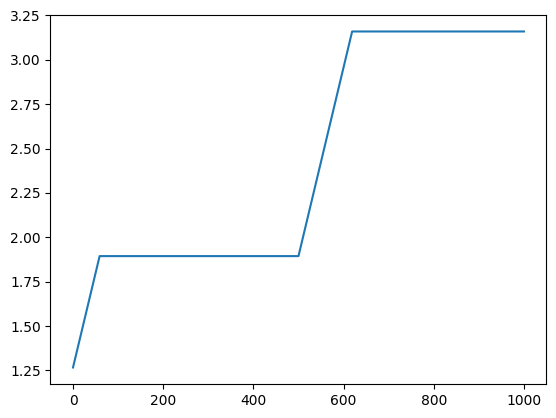

In [766]:
kdv_mass_opt_control = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1,1))

plt.plot(kdv_mass_opt_control)

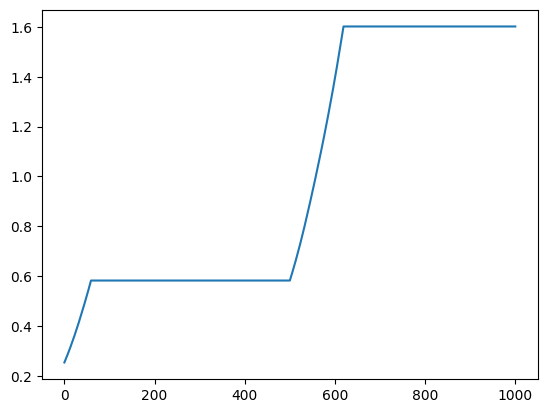

In [767]:
kdv_momentum_opt_control = dx * tf.reshape(tf.math.reduce_sum(tf.square(kdv_opt_control), axis=-1), shape=(-1,1))

plt.plot(kdv_momentum_opt_control)

In [768]:
np.savetxt(os.path.join(data_path,'exact_soln_kdv_opt_control_20s_greedy.csv'), control_exact_opt, delimiter=',')
np.savetxt(os.path.join(data_path,'exact_soln_kdv_opt_soln_20s_greedy.csv'), kdv_opt_control, delimiter=',')